### CS767 Term Project | Yi Rong | 11/30/2020

In [1]:
import pandas as pd
import re
import pdb
import json
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.decomposition import PCA
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import time

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pytz
from pytz import timezone
from datetime import date
import pandas_datareader as web
import io
import pickle
from pandas.tseries.offsets import BDay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import math
import time

F:\Anaconda\envs\tensorflow\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [138]:
#Supress default INFO logging

logger = logging.getLogger('my-logger')
logger.propagate = False

path

In [2]:
reuters_data_path = "F:\\YI RONG\\Kaggle\\dataset\\Reuters_Articles\\reuters_data.csv"
analyst_data_path = "F:\\YI RONG\\Kaggle\\dataset\\Analysts_News\\analyst_ratings_processed.csv"
stock_px_chg_path = "F:\YI RONG\QuantWork\stock_raw\stock_px_chg.pickle"

load data

In [3]:
df_reuters_raw = pd.read_csv(reuters_data_path, encoding = "ISO-8859-1", index_col=0)

df_reuters_raw = df_reuters_raw.set_index('article_publish_date')

df_reuters_raw.index = pd.to_datetime(df_reuters_raw.index, format='%Y-%m-%d %H:%M:%S', errors='coerce')

df_reuters_raw.index = df_reuters_raw.index.tz_convert("US/Eastern")

df_reuters_raw = df_reuters_raw.loc[:, ~df_reuters_raw.columns.str.contains('^Unnamed')]

F:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


load labels

In [72]:
with open(stock_px_chg_path, 'rb') as f:
    try:
        dict_stock_px_chg = pickle.load(f)
    except io.UnsupportedOperation:
        print("stock_px_chg load error")

Process News Data and Return Bag of Words

In [ ]:
def data_processor(dict_stock_px_chg, df_reuters_raw, ticker):
    df_stock = dict_stock_px_chg[ticker]
    
    def _foo(t):
        if t.hour < 16:
            if t.date() in df_stock.index:
                return t.date()
            elif (t + BDay(1)).date() in df_stock.index:
                return (t + BDay(1)).date()
            else:
                return (t + BDay(2)).date()
        elif (t + BDay(1)).date() in df_stock.index:
                return (t + BDay(1)).date()
        else:
                return (t + BDay(2)).date() 
    
    df_X = df_reuters_raw[df_reuters_raw["stock"] == ticker]
    df_X.index = df_X.index.map(_foo)
    df_X = df_X.sort_index(ascending=True)
    
    df_combine = pd.merge(left=df_X, right=df_stock, how='left', left_index=True, right_index=True)
    
    # clean text data
    porter = PorterStemmer()
    def get_clean_text(text):
        # remove extra whitespace
        striptext = text.replace('\n\n', ' ')
        striptext = striptext.replace('\n', ' ')

        # split text into words
        L_words = word_tokenize(striptext)

        # convert word to lowercase
        L_lowercase_words = [word.lower() for word in L_words]

        # exclude all the stopwords and non-alphabets words
        L_ignore = []
        L_drop_stop_nonalpha = [word for word in L_lowercase_words 
                                if word not in stopwords.words() and word not in L_ignore and word.isalpha()]

        # stemming
        L_stemming = [porter.stem(word) for word in L_drop_stop_nonalpha]

        return L_stemming
    
    print("Start cleaning text data")
    # clean all news
    L_clean = []
    for text in df_combine['processed_header']:
        L_clean.append(get_clean_text(text))

    # join words together for each news
    str1 = " " 
    L_comp = []
    for i in range(len(L_clean)):
        L_comp.append(" ".join(L_clean[i]))

    # convert words to vector using Bag of Words
    vectorizer = CountVectorizer(analyzer='word', 
                                  min_df=1, # minimum reqd occurences of a word
                                  ngram_range=(1, 1)) # ngram = 1 or 2
    X2 = vectorizer.fit_transform(L_comp)
    df_bow = pd.DataFrame(X2.toarray(), columns=vectorizer.get_feature_names())
    df_bow.index.name = 'News Number'
    
    return [df_bow, df_combine]

Train a MLP

In [ ]:
def mlp_trainer(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, checkpoint_path):
    # Creating the model
    model = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[X_train.shape[1]]),
            keras.layers.BatchNormalization(),

            keras.layers.Dense(2048, name="Hidden1", kernel_regularizer=keras.regularizers.l1(0.0005), 
                               kernel_constraint=keras.constraints.MaxNorm(max_value=2, axis=0)),
            keras.layers.BatchNormalization(),
            keras.layers.Activation(activations.relu),
            keras.layers.Dropout(rate=0.5),

            keras.layers.Dense(512, name="Hidden2", kernel_regularizer=keras.regularizers.l1(0.0005),
                              kernel_constraint=keras.constraints.MaxNorm(max_value=2, axis=0)),
            keras.layers.BatchNormalization(),
            keras.layers.Activation(activations.relu),
            keras.layers.Dropout(rate=0.5),

            keras.layers.Dense(128, name="Hidden3", kernel_regularizer=keras.regularizers.l1(0.0005),
                              kernel_constraint=keras.constraints.MaxNorm(max_value=2, axis=0)),
            keras.layers.BatchNormalization(),
            keras.layers.Activation(activations.relu),
            keras.layers.Dropout(rate=0.5),

            keras.layers.BatchNormalization(),
            keras.layers.Dense(2, activation="softmax",name="Output")
        ])

    # start from a known place
    keras.backend.clear_session()
    InitSeed=767
    tf.random.set_seed(InitSeed)
    np.random.seed(InitSeed)

    early_stopping = EarlyStopping(    
    monitor='val_loss', 
    patience=20, 
    min_delta=0.1, # minimal monitor improve
    mode='min')
    
    def _step_decay_fn(epoch):
        lr0=0.1
        drop=0.5
        epochs_drop=20
        lrate = lr0 * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lrate

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_best_only=True, 
                                                     save_weights_only=False, 
                                                     monitor='val_loss', 
                                                     mode='min', # measure with accuracy
                                                     verbose=0)
    
    # Compiling the model
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=0.1), 
                metrics=["accuracy"])

    lr_scheduler = keras.callbacks.LearningRateScheduler(_step_decay_fn)

    history = model.fit(X_train , Y_train , 
                        epochs=100,
                        callbacks=[early_stopping, cp_callback, lr_scheduler],
                        validation_data=(X_valid,Y_valid),
                        verbose=0) # no epoch result for simplicity

    return [history.history, model]
    

Production for ALL Tickers and Labels

In [ ]:
L_ticker = list(dict_stock_px_chg.keys())[:-1]
L_label = ["rl_rt_1", "rl_rt_3", "rl_rt_5", "rl_rt_10", "rl_rt_21", "rl_rt_63"]
root_path = "F:\\YI RONG\\BU\\academic\\CS 767 Machine Learning\\Term Paper\\"

dict_mlp_production_result_path = root_path + "mlp_result\\dict_mlp_production_result.pickle"
with open(dict_mlp_production_result_path, 'rb') as f:
    try:
        dict_mlp_production_result = pickle.load(f)
    except io.UnsupportedOperation:
        dict_mlp_production_result = {}

In [ ]:
InitSeed = 767
for ticker in L_ticker:
    
    start = time.time()
    print("Start data processing: " + ticker)
    
    if ticker not in dict_mlp_production_result.keys():
        dict_mlp_production_result[ticker] = {}
        
        L_data_result = data_processor(dict_stock_px_chg, df_reuters_raw, ticker)

        dict_mlp_production_result[ticker]["df_bow"] = L_data_result[0]
        dict_mlp_production_result[ticker]["df_combine"] = L_data_result[1]
    
    if ("df_bow" not in dict_mlp_production_result[ticker].keys()) or \
            ("df_combine" not in dict_mlp_production_result[ticker].keys()):
        
        L_data_result = data_processor(dict_stock_px_chg, df_reuters_raw, ticker)

        dict_mlp_production_result[ticker]["df_bow"] = L_data_result[0]
        dict_mlp_production_result[ticker]["df_combine"] = L_data_result[1]
    
    end = time.time()
    print("Time taken on data processing: " + str(end - start))
    
    for label in L_label:
        
        start = time.time()
        print("Start training: " + label)
        
        if label not in dict_mlp_production_result[ticker].keys():
            dict_mlp_production_result[ticker][label] = {}
        
            L_Y = np.where(dict_mlp_production_result[ticker]["df_combine"][label] >= 0, 1, 0)

            X_train, X_test, Y_train, Y_test = train_test_split(dict_mlp_production_result[ticker]["df_bow"].values, \
                                                                L_Y, \
                                                                test_size=0.2, random_state=InitSeed)
            X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=InitSeed)    

            checkpoint_path = root_path + "mlp_model\\mlp_model_" + ticker + "_" + label + "\\cp.ckpt"

            result = mlp_trainer(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, checkpoint_path)

            dict_mlp_production_result[ticker][label]["history"] = result[0]

            # Plot the learing curve 
            pd.DataFrame(result[0]).plot(figsize=(8, 5)) 
            plt.grid(True)
            plt.gca().set_ylim(0, 5) 
            plt.show()

            model2 = keras.models.load_model(checkpoint_path)

            # Evaluate the classification
            dict_mlp_production_result[ticker][label]["evaluate"] = model2.evaluate(X_test, Y_test)
            print(dict_mlp_production_result[ticker][label]["evaluate"])

            with open(dict_mlp_production_result_path, 'wb') as f:
                pickle.dump(dict_mlp_production_result, f)
                f.close()
                
        end = time.time()
        print("Time taken on training: " + str(end - start))

============================================================================================================

Result Presentation

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
root_path = "F:\\YI RONG\\BU\\academic\\CS 767 Machine Learning\\Term Paper\\"

dict_mlp_production_result_path = root_path + "mlp_result\\dict_mlp_production_result.pickle"
with open(dict_mlp_production_result_path, 'rb') as f:
    try:
        dict_mlp_production_result = pickle.load(f)
    except io.UnsupportedOperation:
        dict_mlp_production_result = {}

Input Data Shape

In [10]:
for ticker in dict_mlp_production_result.keys():
    print(ticker + " bag of words shape: " + str(dict_mlp_production_result[ticker]['df_bow'].shape))

BA bag of words shape: (2340, 2162)
AAPL bag of words shape: (1879, 2184)
FB bag of words shape: (1368, 1980)
TSLA bag of words shape: (1307, 1691)
DB bag of words shape: (1081, 1492)


Learning Curve

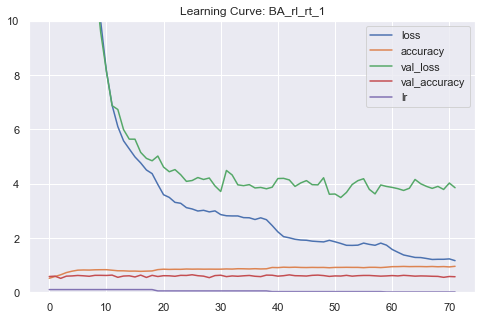

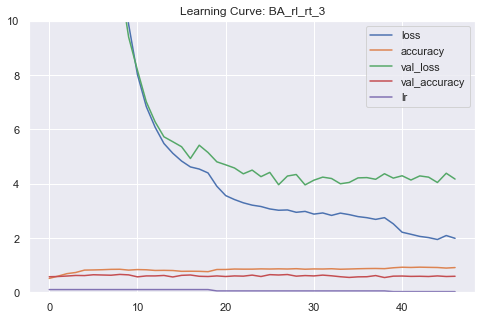

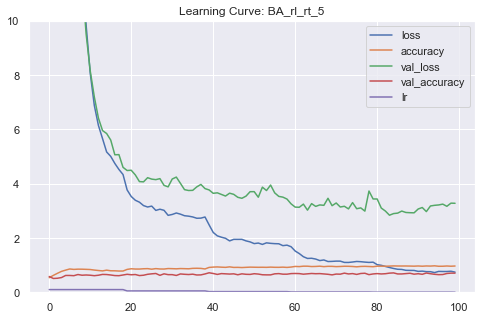

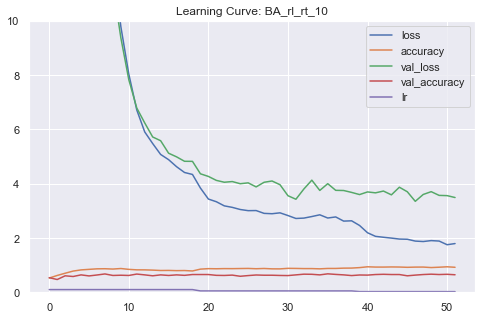

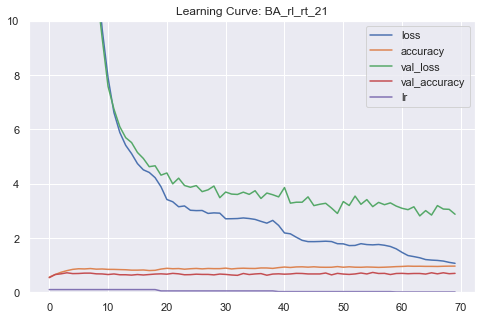

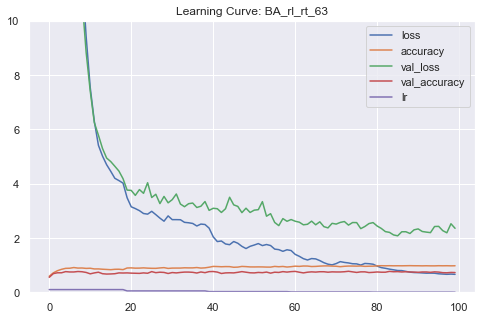

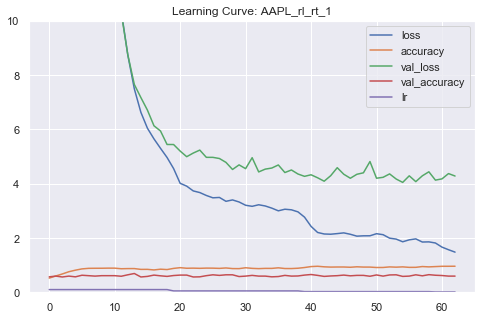

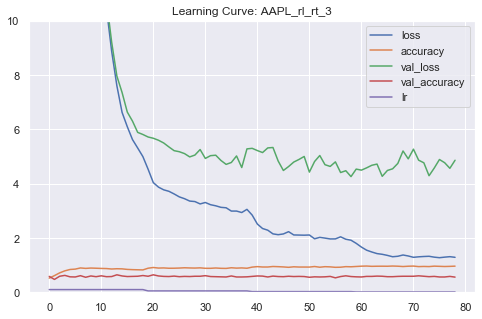

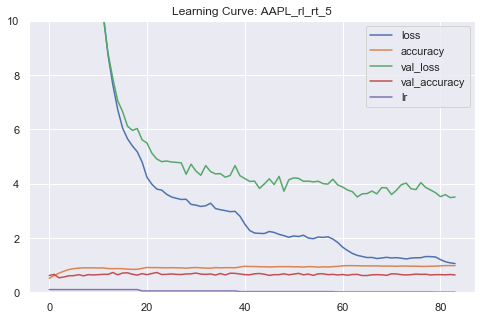

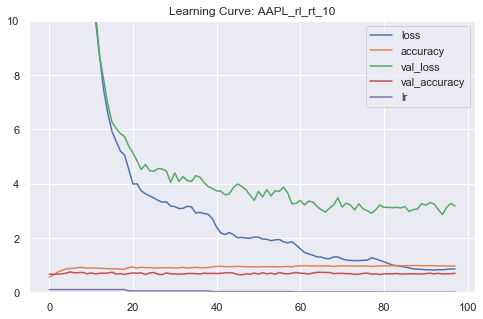

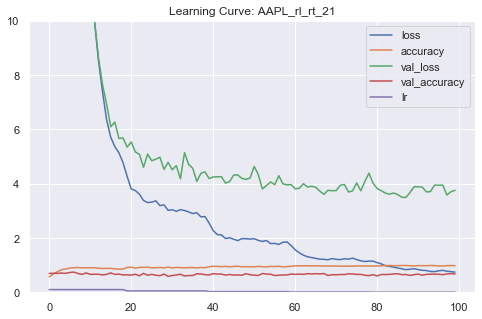

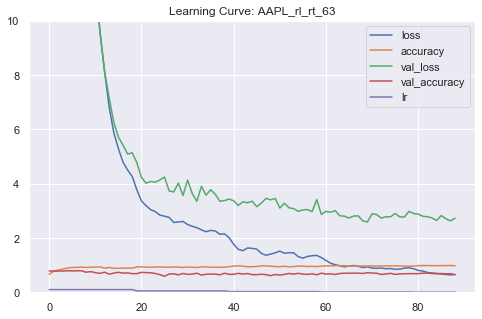

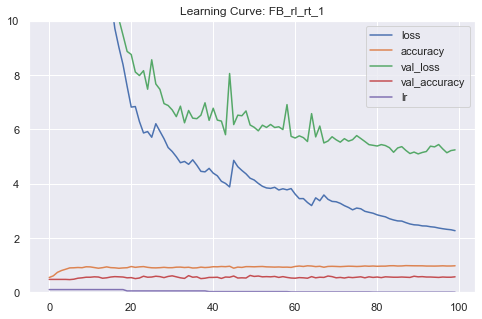

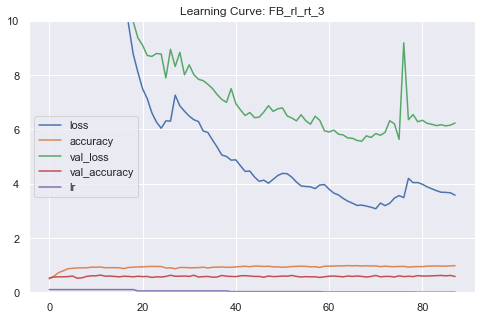

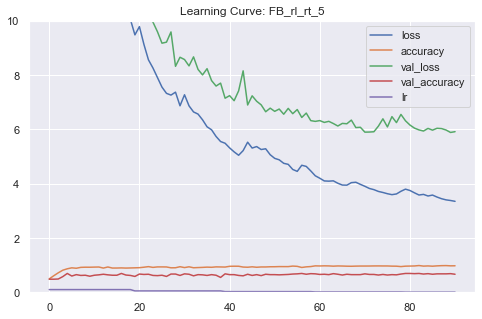

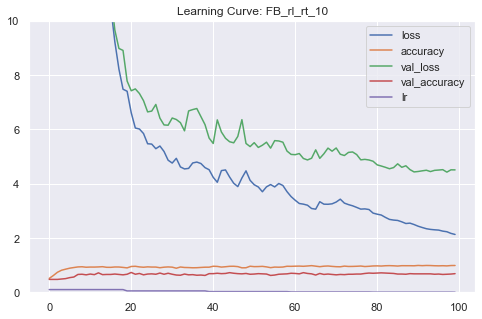

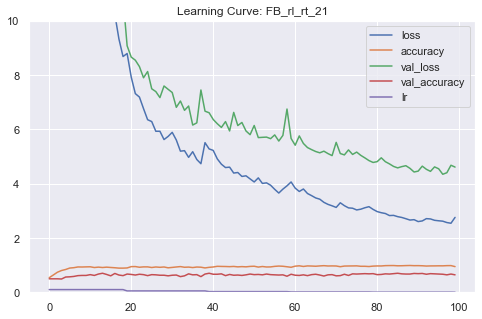

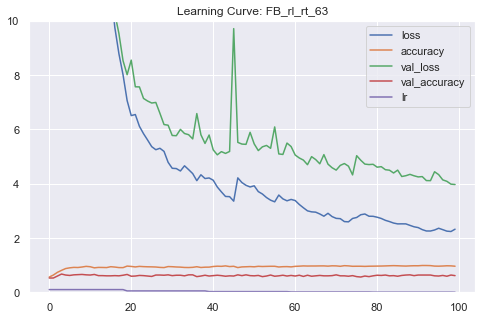

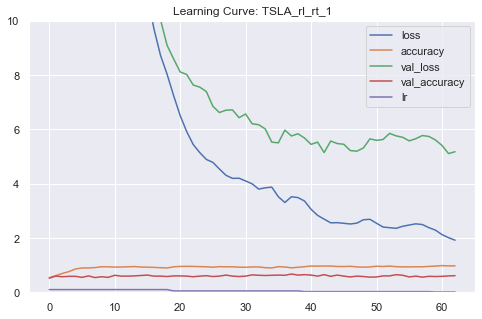

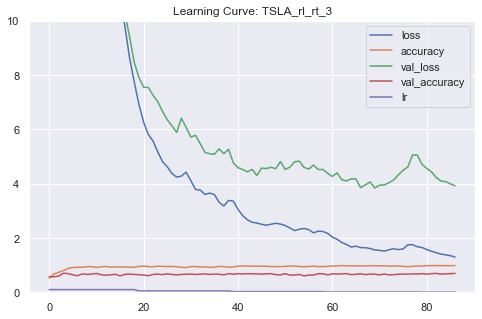

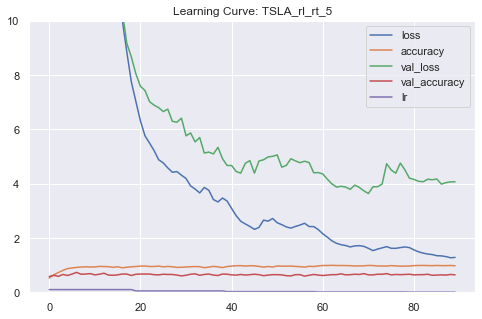

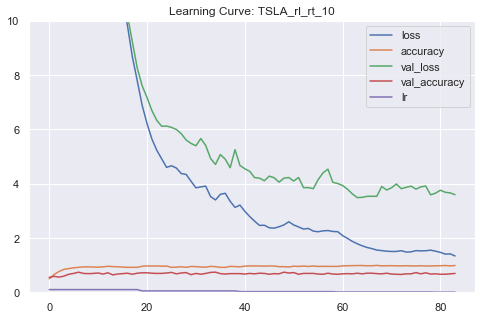

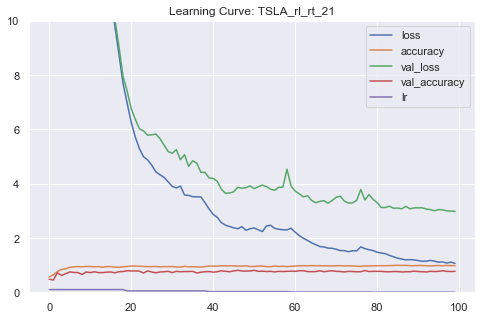

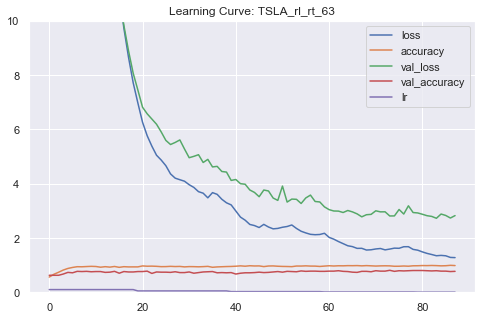

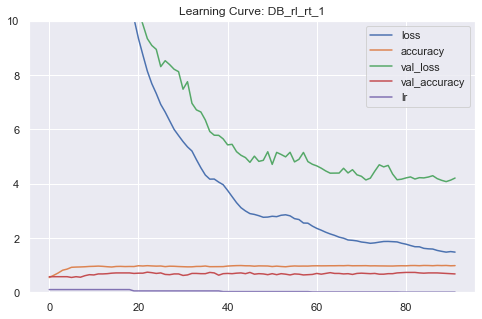

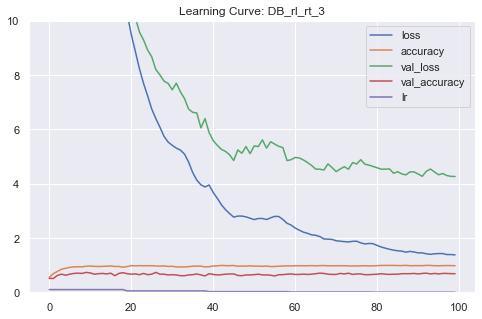

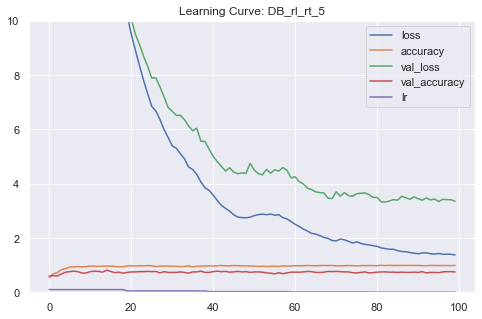

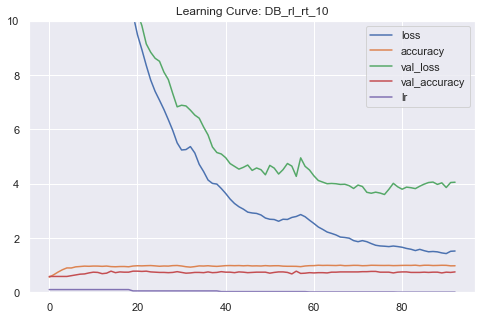

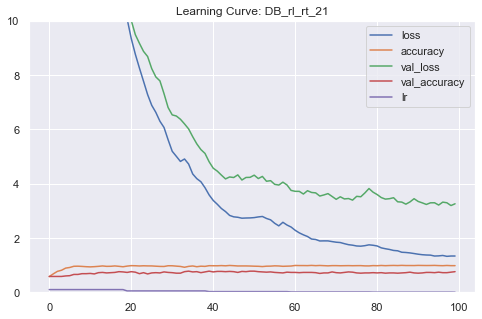

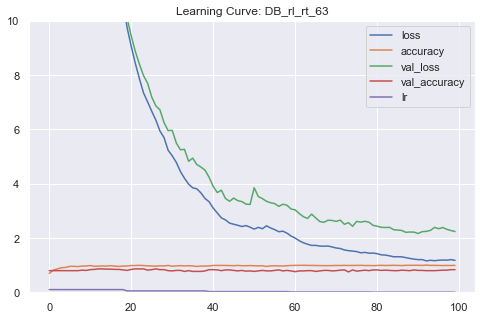

In [18]:
for ticker in dict_mlp_production_result.keys():
    for label in dict_mlp_production_result[ticker].keys():
        if "rt" in label:
            result = dict_mlp_production_result[ticker][label]["history"]
            # Plot the learing curve 
            pd.DataFrame(result).plot(figsize=(8, 5)) 
            plt.grid(True)
            plt.gca().set_ylim(0, 10) 
            plt.title("Learning Curve: " + ticker + "_" + label)
            plt.show()

Accuracy Visualization

In [19]:
for ticker in dict_mlp_production_result.keys():
    for label in dict_mlp_production_result[ticker].keys():
        if "rt" in label:
            result = dict_mlp_production_result[ticker][label]["evaluate"]
            print("Accuracy " + ticker + "_" + label + ":")
            print(result)

Accuracy BA_rl_rt_1:
[3.262007134592431, 0.67094016]
Accuracy BA_rl_rt_3:
[3.815450334141397, 0.6282051]
Accuracy BA_rl_rt_5:
[3.036245794377775, 0.6837607]
Accuracy BA_rl_rt_10:
[3.381409151941283, 0.6837607]
Accuracy BA_rl_rt_21:
[2.683698696967883, 0.72649574]
Accuracy BA_rl_rt_63:
[1.9208041541596763, 0.8076923]
Accuracy AAPL_rl_rt_1:
[3.988456908692705, 0.60638297]
Accuracy AAPL_rl_rt_3:
[3.917779694212244, 0.64361703]
Accuracy AAPL_rl_rt_5:
[3.5332914159653033, 0.65957445]
Accuracy AAPL_rl_rt_10:
[2.7649919454087604, 0.7180851]
Accuracy AAPL_rl_rt_21:
[3.183305928047667, 0.68085104]
Accuracy AAPL_rl_rt_63:
[2.6054853987186513, 0.71276593]
Accuracy FB_rl_rt_1:
[5.069488720302164, 0.5985401]
Accuracy FB_rl_rt_3:
[5.668201836356281, 0.6277372]
Accuracy FB_rl_rt_5:
[6.351814837351332, 0.5985401]
Accuracy FB_rl_rt_10:
[5.002186975339903, 0.6423358]
Accuracy FB_rl_rt_21:
[5.319522300775904, 0.6131387]
Accuracy FB_rl_rt_63:
[4.504812372861988, 0.63503647]
Accuracy TSLA_rl_rt_1:
[4.48749

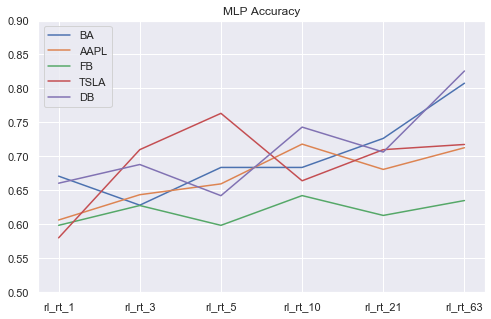

In [4]:
dict_accuracy = {}
for ticker in dict_mlp_production_result.keys():
    dict_accuracy[ticker] = {}
    for label in dict_mlp_production_result[ticker].keys():
        if "rt" in label:
            result = dict_mlp_production_result[ticker][label]["evaluate"]
            dict_accuracy[ticker][label] = result[1]

df_accuracy = pd.DataFrame(dict_accuracy)
df_accuracy.plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0.5, 0.9) 
plt.title("MLP Accuracy")
plt.show()

===============================================================================

MLP Production Predictor

In [ ]:
root_path = "F:\\YI RONG\\BU\\academic\\CS 767 Machine Learning\\Term Paper\\"

dict_mlp_production_result_path = root_path + "mlp_result\\dict_mlp_production_result.pickle"
with open(dict_mlp_production_result_path, 'rb') as f:
    try:
        dict_mlp_production_result = pickle.load(f)
    except io.UnsupportedOperation:
        dict_mlp_production_result = {}

In [123]:
def get_bow(L_str):
    
    # clean text data
    porter = PorterStemmer()
    def _get_clean_text(text):
        # remove extra whitespace
        striptext = text.replace('\n\n', ' ')
        striptext = striptext.replace('\n', ' ')

        # split text into words
        L_words = word_tokenize(striptext)

        # convert word to lowercase
        L_lowercase_words = [word.lower() for word in L_words]

        # exclude all the stopwords and non-alphabets words
        L_ignore = []
        L_drop_stop_nonalpha = [word for word in L_lowercase_words 
                                if word not in stopwords.words() and word not in L_ignore and word.isalpha()]

        # stemming
        L_stemming = [porter.stem(word) for word in L_drop_stop_nonalpha]

        return L_stemming
    
    # clean all news
    L_clean = []
    for text in L_str:
        L_clean.append(_get_clean_text(text))

    # join words together for each news
    str1 = " " 
    L_comp = []
    for i in range(len(L_clean)):
        L_comp.append(" ".join(L_clean[i]))

    # convert words to vector using Bag of Words
    vectorizer = CountVectorizer(analyzer='word', 
                                  min_df=1, # minimum reqd occurences of a word
                                  ngram_range=(1, 1)) # ngram = 1 or 2
    X2 = vectorizer.fit_transform(L_comp)
    df_bow = pd.DataFrame(X2.toarray(), columns=vectorizer.get_feature_names())
    df_bow.index.name = 'News Number'    
    
    return df_bow

In [132]:
L_str = ["Deutsche Bank's revenue dropped this year",
         "Deutsche Bank to sell IT unit to Tata as it trims staff",
         "Deutsche Bank Tightens Conditions for Loans to Wealthy Clients",
         "Deutsche Bank halves bonuses for board members"]
root_path = "F:\\YI RONG\\BU\\academic\\CS 767 Machine Learning\\Term Paper\\"

In [133]:
def mlp_predictor(L_str, ticker):
    
    dict_mlp_predict = {}
    for text in L_str:
        dict_mlp_predict[text] = {}
        
    df_bow_new = get_bow(L_str)
    
    L_label = ["rl_rt_1", "rl_rt_3", "rl_rt_5", "rl_rt_10", "rl_rt_21", "rl_rt_63"]
    
    for label in L_label:
        df_bow_full = dict_mlp_production_result["DB"]["df_bow"].iloc[0:0]
        df_bow_test = df_bow_full.append(df_bow_new).iloc[:,:df_bow_full.shape[1]]
        df_bow_test = df_bow_test.fillna(0)
        
        checkpoint_path = root_path + "mlp_model\\mlp_model_" + ticker + "_" + label + "\\cp.ckpt"
        model2 = keras.models.load_model(checkpoint_path)
        results = model2.predict_classes(df_bow_test.values)
        
        for i, text in enumerate(L_str):
            dict_mlp_predict[text][label] = results[i]
    
    return dict_mlp_predict

In [134]:
ticker = "DB"
dict_mlp_predict = mlp_predictor(L_str, ticker)

In [135]:
pd.DataFrame(dict_mlp_predict).T

,rl_rt_1,rl_rt_3,rl_rt_5,rl_rt_10,rl_rt_21,rl_rt_63
Deutsche Bank's revenue dropped this year,0,0,0,0,0,0
Deutsche Bank to sell IT unit to Tata as it trims staff,0,0,0,0,0,1
Deutsche Bank Tightens Conditions for Loans to Wealthy Clients,1,0,1,1,1,0
Deutsche Bank halves bonuses for board members,1,1,1,1,1,0


In [ ]:
L_str = ["Deutsche Bank's revenue dropped this year",
         "Deutsche Bank to sell IT unit to Tata as it trims staff",
         "Deutsche Bank Tightens Conditions for Loans to Wealthy Clients",
         "Deutsche Bank halves bonuses for board members"]